In [1]:
%matplotlib notebook 
import json
import numpy 
import os
import sys
import time

import skimage.io
import skimage.transform
import skimage.color
import skimage.feature 
import skimage.measure

import scipy.signal
import scipy.ndimage

import matplotlib.pyplot
import matplotlib.patches

# Create bounding boxes for all non mitotic cells
This notebook performs three tasks
1. Bounding boxes for all reference cells are created 
2. All bounding boxes for mitotic cells are removed 
3. The remaining bounding boxes are enlarged by a defined offset 

In [2]:
data_dir = '../data/'
filename_mitosis = data_dir + 'mitosis_templates.json' 
mask_dir = data_dir + 'mask/'

offset = 10

In [3]:
def to_dict(x1, y1, x2, y2):
    return {
        "class": "cell",
        "x1": y1,
        "x2": y2,
        "y1": x1,
        "y2": x2
    }

def box_list(pathname):
    image = skimage.io.imread(pathname)
    region_list = skimage.measure.regionprops(image)
    return [to_dict(*region.bbox) for region in region_list]

# Read reference data
All reference images are loaded and all stored masks are stored as a bbox. Remember that this list includes all cells including mitotic cells!

In [4]:
# read all cell masks 
import glob

pathnames = glob.glob(mask_dir + "ref*.png")

template_list = []

for pathname in pathnames:
    template = {
        "boxes": box_list(pathname),
        "filename": os.path.basename(pathname),
        "shape" : [1376, 1038, 3]
    }
    
    template_list += [template]

## Load bounding boxes of all mitotic cells 
These data is created using the notebook  ```2017_06_create_mitosis_bbox_template_matching```

In [5]:
# load mitotic cells 

with open(filename_mitosis, "r") as f:
    mitosis_list = json.loads(f.read())

In [6]:
# sort the stuff 
sorted_mitosis_list = sorted(mitosis_list, key=lambda element: element["filename"])
sorted_cell_list = sorted(template_list, key=lambda element: element["filename"])
sorted_mitosis_list[1]

{'boxes': [{'class': 'mitosis', 'x1': 410, 'x2': 451, 'y1': 30, 'y2': 71}],
 'filename': 'refdataB_014.png',
 'shape': [1376, 1038, 3]}

## Sample image

<IPython.core.display.Javascript object>


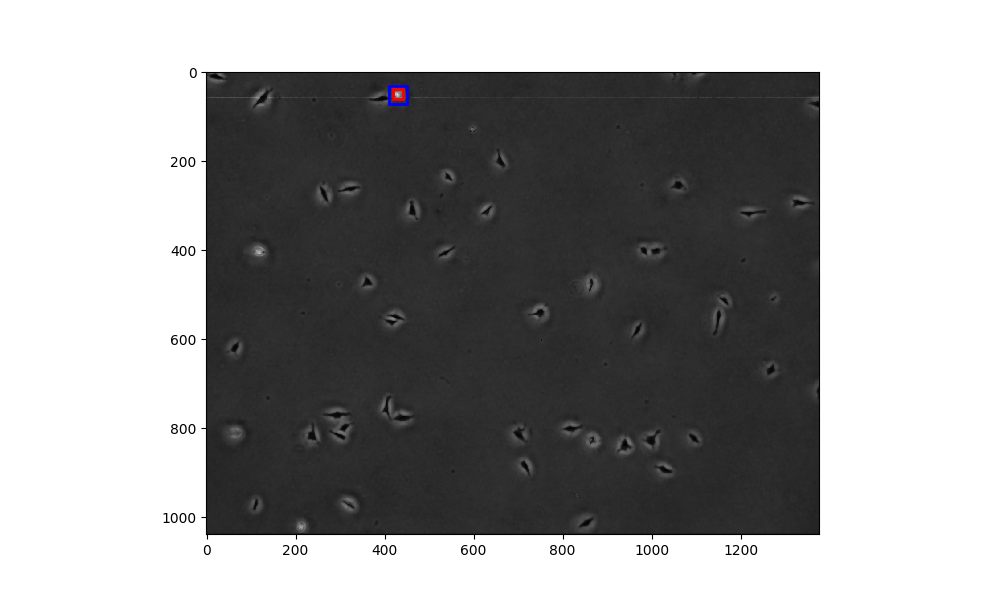

In [12]:
I_cell = skimage.io.imread("../data/cetres.b_adapted/refdataB_C2_014.png")

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
ax.imshow(I_cell,cmap="gray")     
    
minr, minc, maxr, maxc = [38, 419, 61, 442]
rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, 
                                    maxr - minr, fill = False, edgecolor = 'red', 
                                    linewidth = 2)
ax.add_patch(rect)

minr, minc, maxr, maxc = [30, 410, 71, 451]
rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, 
                                    maxr - minr, fill = False, edgecolor = 'blue', 
                                    linewidth = 2)
ax.add_patch(rect)

## Remove mitotic cells 

In [8]:
def norm2(x1,x2,y1,y2):
    return (numpy.sqrt((x1-x2)*(x1-x2) + (y1 - y2)*(y1 - y2)))

def same_bounding_box(bbox1, bbox2):
    x1 = 1/2 * (bbox1["x1"] + bbox1["x2"]) 
    x2 = 1/2 * (bbox2["x1"] + bbox2["x2"]) 
    y1 = 1/2 * (bbox1["y1"] + bbox1["y2"]) 
    y2 = 1/2 * (bbox2["y1"] + bbox2["y2"])
    return (norm2(x1,x2,y1,y2) < 10)

def remove_duplicates(mito_list, cell_list):
    bad_cells = []

    for mito_box in mito_list["boxes"]:
        for cell_box in cell_list["boxes"]:
            if same_bounding_box(cell_box, mito_box):
                bad_cells += [cell_box]
                break

    for bad_cell in bad_cells:
        try:
            cell_list["boxes"].remove(bad_cell)
        except ValueError as e:
            continue
            
    return bad_cells

In [9]:
duplicate_cells = []

for mito_list in sorted_mitosis_list:
    for cell_list in sorted_cell_list:
        if cell_list["filename"][-7:] == mito_list["filename"][-7:]:
            duplicate_cells += [remove_duplicates(mito_list, cell_list)] 

## Enlarge bounding boxes 

In [10]:
x,y,z = skimage.io.imread('../data/cetres.b/refdataB_C2_001.png').shape
print(x,y)

for element in sorted_cell_list:
    print(element["filename"])
    for box in element["boxes"]:
        box["x1"] = max(0, box["x1"] - offset)
        box["x2"] = min(x, box["x2"] + offset)
        box["y1"] = max(0, box["y1"] - offset)
        box["y2"] = min(y, box["y2"] + offset)

1038 1376
refdataB_001.png
refdataB_002.png
refdataB_003.png
refdataB_004.png
refdataB_005.png
refdataB_006.png
refdataB_007.png
refdataB_008.png
refdataB_009.png
refdataB_010.png
refdataB_011.png
refdataB_012.png
refdataB_013.png
refdataB_014.png
refdataB_015.png
refdataB_016.png
refdataB_017.png
refdataB_018.png
refdataB_019.png
refdataB_020.png
refdataB_021.png
refdataB_022.png
refdataB_023.png
refdataB_024.png
refdataB_025.png
refdataB_026.png
refdataB_027.png
refdataB_028.png
refdataB_029.png
refdataB_030.png
refdataB_031.png
refdataB_032.png
refdataB_033.png
refdataB_034.png
refdataB_035.png
refdataB_036.png
refdataB_037.png
refdataB_038.png
refdataB_039.png
refdataB_040.png
refdataB_041.png
refdataB_042.png
refdataB_043.png
refdataB_044.png
refdataB_045.png
refdataB_046.png
refdataB_047.png
refdataB_048.png
refdataB_049.png
refdataB_050.png
refdataB_051.png
refdataB_052.png
refdataB_053.png
refdataB_054.png
refdataB_055.png
refdataB_056.png
refdataB_057.png
refdataB_058.png
refd

In [11]:
with open('../data/bbox_cells_enlarged.json', 'w') as fp:
    json.dump(sorted_cell_list, fp, indent=4)